In [1]:
def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    imgs_train = imgs_train[:1000]
    imgs_mask_train = np.load('imgs_mask_train.npy')
    imgs_mask_train = imgs_mask_train[:1000]
    return imgs_train, imgs_mask_train

def load_test_data():
    imgs_test = np.load('imgs_test.npy')
    imgs_test = imgs_test[:300]
    imgs_id = np.load('imgs_id_test.npy')
    imgs_id = imgs_id[:300]
    return imgs_test, imgs_id


In [1]:
from __future__ import print_function

import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

K.set_image_dim_ordering('tf')  # Tensor Flow dimension ordering in this code
img_rows = 64
img_cols = 80

smooth = 1.



def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


Using TensorFlow backend.


In [4]:
from keras import optimizers
from keras.layers import Activation, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.utils.layer_utils import print_summary


def get_unet_1():
    inputs = Input((1, img_rows, img_cols))
    dropout1 = Dropout(0.25)(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same',dim_ordering='th')(dropout1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same',dim_ordering='th')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2),dim_ordering='th')(conv1)
    #imshow(l.activation(inpic)) 

    #dropout2 = Dropout(0.25)(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same',dim_ordering='th')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same',dim_ordering='th')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2),dim_ordering="th")(conv2)


    up9 = merge([UpSampling2D(size=(2, 2),dim_ordering='th')(conv2), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same',dim_ordering='th')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same',dim_ordering='th')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid',dim_ordering='th')(conv9)

    model = Model(input=inputs, output=conv10)

    #model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    #model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])
    #sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

    #rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
    #model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=[dice_coef])
    #model.compile(optimizer=rmsprop, loss='binary_crossentropy')
    #model.compile(optimizer='adam', loss=dice_coef_loss, metric='accuracy',dim_ordering="th")
    #metrics={'outbin': 'accuracy'}

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    print_summary(model.layers)
    return model

In [21]:

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], imgs.shape[1], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i, 0] = cv2.resize(imgs[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    return imgs_p


def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet_1()
    model_checkpoint = ModelCheckpoint('model1.hdf5', monitor='loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train, imgs_mask_train, batch_size=32, nb_epoch=50, verbose=1, shuffle=True,
              callbacks=[model_checkpoint])

    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test, imgs_id_test = load_test_data()
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('model1.hdf5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test_model1.npy', imgs_mask_test)


In [ ]:

train_and_predict()
#keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1, 64, 80)     0                                            
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 1, 64, 80)     0           input_3[0][0]                    
____________________________________________________________________________________________________
convolution2d_15 (Convolution2D) (None, 32, 64, 80)    320         dropout_3[0][0]                  
_________________________________________________________________________________________________

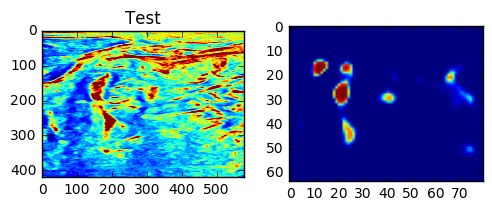

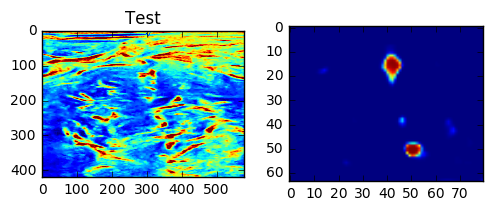

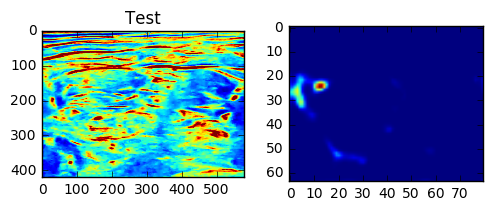

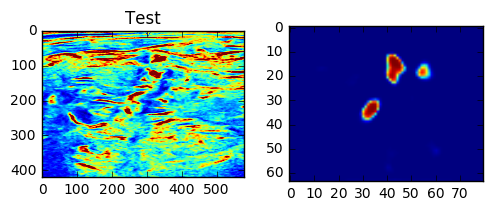

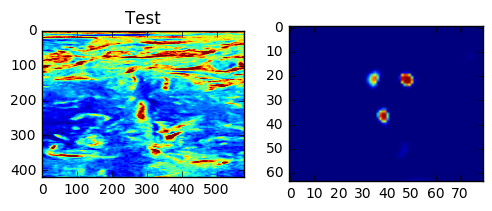

In [3]:
from matplotlib.pyplot import imshow
from matplotlib import pyplot
import numpy as np
imgs_test = np.load("imgs_test.npy")

imgs_mask_test_augment = np.load("imgs_mask_test_model1.npy")

imgs_mask_test_augment = imgs_mask_test_augment.astype('float32')

#imgs_mask_test_augment -= mean
#imgs_mask_test_augment /= std
imgs_mask_test_augment /= 255.  # scale masks to [0, 1]

import pylab as pl
for i in range(5):
    pl.figure(figsize=(12, 2))
    pl.subplot(142)
    pl.title('Test')
    pl.imshow(imgs_test[i].squeeze())
    pl.subplot(143)
    pl.imshow(imgs_mask_test_augment[i].squeeze())
    pyplot.show()


In [7]:
#Validation
from matplotlib.pyplot import imshow
from matplotlib import pyplot
import cv2
from keras.layers import *
from keras.models import Model


import numpy as np
img_rows = 64
img_cols = 80


def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], imgs.shape[1], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i, 0] = cv2.resize(imgs[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    return imgs_p
#Create Test Set
imgs_train = np.load("imgs_train.npy")
imgs_train = imgs_train[:20]
#To validate
imgs_mask_train = np.load("imgs_mask_train.npy")
imgs__mask_train = imgs_train[:20]
#Pre process
imgs_train = preprocess(imgs_train)
imgs_mask_train = preprocess(imgs_mask_train)
#Mean for standardization
imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255.  # scale masks to [0, 1]

#Predicting on train images
print('-'*30)
print('Loading saved weights...')
print('-'*30)
model = get_unet_1()
model.load_weights('model1.hdf5')

print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
imgs_mask_test = model.predict(imgs_train, verbose=1)
np.save('imgs_mask_validate_model1.npy', imgs_mask_test)

------------------------------
Loading saved weights...
------------------------------
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1, 64, 80)     0                                            
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 1, 64, 80)     0           input_3[0][0]                    
____________________________________________________________________________________________________
convolution2d_15 (Convolution2D) (None, 32, 64, 80)    320         dropout_3[0][0]                  
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D) (None, 32, 64, 80)    9248        convolution2d_15[0][0]           
____

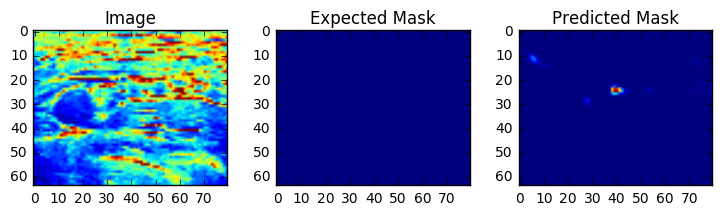

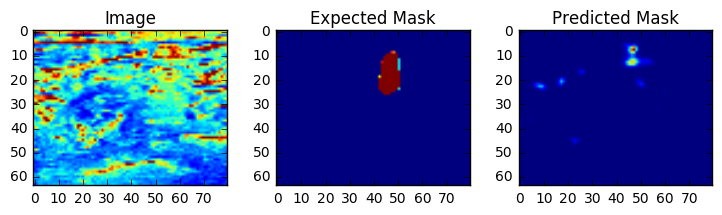

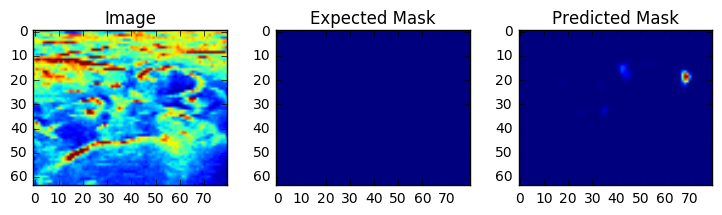

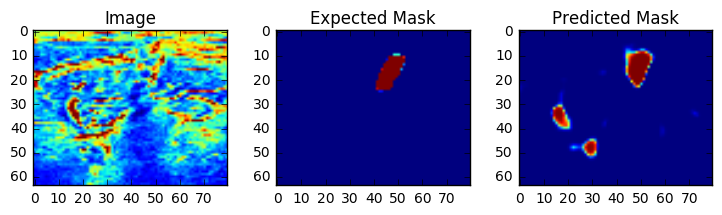

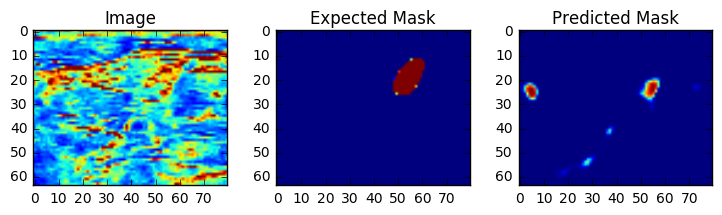

In [8]:
import pylab as pl
import numpy as np
imgs_valid_mask = np.load("imgs_mask_validate_model1.npy")
for i in range(5):
    pl.figure(figsize=(12, 2))
    pl.subplot(142)
    pl.title("Image")
    pl.imshow(imgs_train[i].squeeze())
    pl.subplot(143)
    pl.title("Expected Mask")
    pl.imshow(imgs_mask_train[i].squeeze())
    pl.subplot(144)
    pl.title("Predicted Mask")
    pl.imshow(imgs_valid_mask[i].squeeze())
    pyplot.show()